# Load Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import re
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Feature Extraction
Add features:
- Total word counts (cleaned)
- Urls per comment
- Question marks per comment
- Sklearn vectorizer


**Start from the cleanpost data**

In [ ]:
# new_path = '/content/drive/MyDrive/CS289A Project/data/cleaned_mbti_train.csv'
new_path = '/content/drive/MyDrive/CS289A Project/data/old data (w o removing mbti words)/cleaned_mbti_train.csv'
df_train = pd.read_csv(new_path).drop(columns=['Unnamed: 0'])

In [ ]:
df_train['http_per_comment'] = df_train['posts'].apply(lambda x: x.count('http')/50)
df_train['qm_per_comment'] = df_train['posts'].apply(lambda x: x.count('?')/50)

In [ ]:
# new_path_test = '/content/drive/MyDrive/CS289A Project/data/cleaned_mbti_test.csv'
new_path_test = '/content/drive/MyDrive/CS289A Project/data/old data (w o removing mbti words)/cleaned_mbti_test.csv'
df_test = pd.read_csv(new_path_test).drop(columns=['Unnamed: 0'])

In [ ]:
df_test['http_per_comment'] = df_test['posts'].apply(lambda x: x.count('http')/50)
df_test['qm_per_comment'] = df_test['posts'].apply(lambda x: x.count('?')/50)

**Vectorize Clean Posts**

In [ ]:
# Tf-idf vectorizer
nfeat = 2000
vectorizer = TfidfVectorizer(max_features=nfeat) # max_features may change
vectorizer.fit(df_train.clean_posts)
feature_names=vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Tf-idf vectorizer
train_post=vectorizer.transform(df_train.clean_posts).toarray()
test_post=vectorizer.transform(df_test.clean_posts).toarray()

Concatonate all features to get a **train_design** matrix\
Whitening all features

In [ ]:
# concatenate other features
train_remain = np.stack((df_train.clean_word_counts, df_train.http_per_comment, df_train.qm_per_comment), axis=1)
train_design = np.concatenate((train_post,train_remain), axis=1)

# concatenate other features
test_remain = np.stack((df_test.clean_word_counts, df_test.http_per_comment, df_test.qm_per_comment), axis=1)
test_design = np.concatenate((test_post,test_remain), axis=1)

In [ ]:
X_train_list = []; X_test_list = []
# 0. tfid + 3 add feats w/o whitening
X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [ ]:
# 1. tfid + 3 add feats with whitening the 3 add feats.
train_mean = np.average(train_design,axis=0)
train_var = np.average(train_design,axis=0)
train_design[:,-3:]=(train_design[:,-3:] - train_mean[-3:]) / np.sqrt(train_var[-3:])
test_design[:,-3:]=(test_design[:,-3:] - train_mean[-3:]) / np.sqrt(train_var[-3:])

X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [ ]:
# 2. tfid + 3 add feats with whitening all feats
train_design[:,:-3]=(train_design[:,:-3] - train_mean[:-3]) / np.sqrt(train_var[:-3])
test_design[:,:-3]=(test_design[:,:-3] - train_mean[:-3]) / np.sqrt(train_var[:-3])

X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [ ]:
# 3. tfid w/o whitening
X_train_list.append(np.copy(X_train_list[0][:,:-3])); X_test_list.append(np.copy(X_test_list[0][:,:-3]));
# 4. tfid with whitening
X_train_list.append(np.copy(X_train_list[2][:,:-3])); X_test_list.append(np.copy(X_test_list[2][:,:-3]));

**Setting up y-labels**: 16 classes (ranging from 0-15 representing 16 Myers-briggs personality types)\
INFJ - 0\
INFP - 1\
INTJ - 2\
INTP - 3\
ISFJ - 4\
ISFP - 5\
ISTJ - 6\
ISTP - 7\
ENFJ - 8\
ENFP - 9\
ENTJ - 10\
ENTP - 11\
ESFJ - 12\
ESFP - 13\
ESTJ - 14\
ESTP - 15


In [ ]:
# train/test_pers_bin : splitted MBTI types
# I/E  N/S  F/T  J/P
pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
def trans_per(mtype):
  return [pers[l] for l in mtype]

def bin_2_num(bin):
  res = 0; n = len(bin)
  for ielem, bin_val in enumerate(bin):
    res += bin_val*pow(2,n-1-ielem)
  return res

# can train each personality
train_pers_bin = np.array([trans_per(p) for p in df_train.type])
# train_target
train_target = np.array([bin_2_num(bin) for bin in train_pers_bin])


In [ ]:
class16_mbti_map = {
    0:"INFJ",
    1:"INFP",
    2:"INTJ",
    3:"INTP",
    4:"ISFJ",
    5:"ISFP",
    6:"ISTJ",
    7:"ISTP",
    8:"ENFJ",
    9:"ENFP",
    10:"ENTJ",
    11:"ENTP",
    12:"ESFJ",
    13:"ESFP",
    14:"ESTJ",
    15:"ESTP",
}

In [ ]:
# can train each personality
test_pers_bin = np.array([trans_per(p) for p in df_test.type])
# train_target
test_target = np.array([bin_2_num(bin) for bin in test_pers_bin])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [ ]:
cv = 5 # May change

In [ ]:
y_train = np.copy(train_target)
y_test = np.copy(test_target)

**Brief dim reduction**

In [ ]:
from sklearn.decomposition import PCA
pca_dim = 500
for ielem in range(5):
  pca = PCA(n_components=pca_dim,random_state=248)
  tmp_train = pca.fit_transform(X_train_list[ielem])
  tmp_test = pca.transform(X_test_list[ielem])
  X_train_list.append(tmp_train)
  X_test_list.append(tmp_test)

**Aug data**

In [ ]:
if True:
  # Add Aug Data
  root_path = '/content/drive/MyDrive/CS289A Project/'
  data_path = root_path + 'data/'
  train_aug_data_path = data_path + 'df_train_aug.csv'
  train_aug = pd.read_csv(train_aug_data_path)

  test_aug_data_path = data_path + 'df_test_aug.csv'
  test_aug = pd.read_csv(test_aug_data_path)
  X_train_aug = train_aug.to_numpy()[:,1:]
  X_test_aug = test_aug.to_numpy()[:,1:]
  # train_mean_aug = np.average(X_train_aug,axis=0)
  # train_var_aug = np.var(X_train_aug, axis=0)
  # X_train_aug = (X_train_aug-train_mean_aug)/np.sqrt(train_var_aug)
  # X_test_aug = (X_test_aug-train_mean_aug)/np.sqrt(train_var_aug)

**Sanity check**
- The list of design matrices consist of
0. Tfid vector with add. features(n_features = nfeat+3) w/o whitening
1. Tfid vector with add. features(n_features = nfeat+3) with whitening 3 add feats. 
2. Tfid vector with add. features(n_features = nfeat+3) with complete whitening
3. Tfid vector w/o add. features(n_features = nfeat) w/o whitening
4. Tfid vector w/o add. features(n_features = nfeat) with whitening
5. PCA of 0.
6. PCA of 1.
7. PCA of 2.
8. PCA of 3.
9. PCA of 4.

In [ ]:
print('nfeat = ', nfeat)
print('pca_dim = ', pca_dim)
for design in X_train_list:
  print(design.shape)

nfeat =  2000
pca_dim =  500
(6940, 2003)
(6940, 2003)
(6940, 2003)
(6940, 2000)
(6940, 2000)
(6940, 500)
(6940, 500)
(6940, 500)
(6940, 500)
(6940, 500)


# (DONE) DESIGN MATRICES

# Classification
- Logistic Regression
- SVM
- QDA
- Boosting (this case ada)
- Decision Tree Classifier
- Random Forest
1. compare CV accuracies of all classifiers (GridSearchCV or RandomizedSearchCV)
2. hyperparameter tuning
3. feature selection
4. visualization -- T-sne https://distill.pub/2016/misread-tsne/ compress 2000 features into 2D or 3D,
5. include error bars if appropriate (classifiers with randomness included)

MLP


In [ ]:
from sklearn.model_selection import cross_val_score

**1. Logistic Regression**

**2. SVM**

**3. QDA**

In [ ]:
if False:
  import warnings
  warnings.filterwarnings('ignore')

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_clf_list = []
for X_train in X_train_list:
  qda_clf = QuadraticDiscriminantAnalysis()
  qda_clf.fit(X_train,y_train)
  qda_clf_list.append(qda_clf)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

In [ ]:
for ielem, qda_clf in enumerate(qda_clf_list):
  print('design matrix', ielem)
  print('training score:', qda_clf.score(X_train_list[ielem],y_train))
  print('test score:', qda_clf.score(X_test_list[ielem],y_test))

design matrix 0
training score: 1.0
test score: 0.03227665706051873
design matrix 1
training score: 1.0
test score: 0.057060518731988474
design matrix 2
training score: 1.0
test score: 0.09798270893371758
design matrix 3
training score: 1.0
test score: 0.08587896253602305
design matrix 4
training score: 1.0
test score: 0.10662824207492795
design matrix 5
training score: 0.8123919308357349
test score: 0.2904899135446686
design matrix 6
training score: 0.8123919308357349
test score: 0.2904899135446686
design matrix 7
training score: 0.8550432276657061
test score: 0.2864553314121037
design matrix 8
training score: 0.8121037463976946
test score: 0.29394812680115273
design matrix 9
training score: 0.8544668587896254
test score: 0.2904899135446686


**3-1. LDA**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_clf_list = []
for X_train in X_train_list:
  lda_clf = LinearDiscriminantAnalysis()
  lda_clf.fit(X_train,y_train)
  lda_clf_list.append(lda_clf)

In [ ]:
for ielem, lda_clf in enumerate(lda_clf_list):
  print('design matrix', ielem)
  print('training score:', lda_clf.score(X_train_list[ielem],y_train))
  print('test score:', lda_clf.score(X_test_list[ielem],y_test))

design matrix 5 / 6 looks promising. Let choose 6 and do hyper parameter tuning over PCA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
dim_list = np.linspace(36,40,5,dtype=np.int64)
# pca_lda_list = []
for pca_dim in dim_list:
  print('pca_dim:', pca_dim)
  # pca_dim = 100
  pca = PCA(n_components=pca_dim,random_state=248)
  X_train_tmp = pca.fit_transform(X_train_list[1])
  X_test_tmp = pca.transform(X_test_list[1])
  
  lda_clf = LinearDiscriminantAnalysis()
  lda_clf.fit(X_train_tmp,y_train)

  lda_clf_cv = LinearDiscriminantAnalysis()
  scores = cross_val_score(lda_clf_cv, X_train_tmp, y_train, cv=cv)
  print('training score:', lda_clf.score(X_train_tmp,y_train))
  print('cv result:', scores.mean(), scores.var())
  print('test score:', lda_clf.score(X_test_tmp,y_test))
# further optimization could be done within 20 to 40


pca_dim: 36
training score: 0.6851585014409222
cv result: 0.6740634005763688 0.00011016618359092701
test score: 0.6645533141210375
pca_dim: 37
training score: 0.6863112391930836
cv result: 0.678386167146974 0.0001599963457881055
test score: 0.6697406340057637
pca_dim: 38
training score: 0.6877521613832853
cv result: 0.675936599423631 9.621373817571779e-05
test score: 0.6703170028818444
pca_dim: 39
training score: 0.6889048991354467
cv result: 0.6780979827089337 9.206122465928647e-05
test score: 0.6668587896253603
pca_dim: 40
training score: 0.6865994236311239
cv result: 0.6747838616714696 4.019633083905676e-05
test score: 0.6657060518731989


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
dim_list = np.linspace(100,500,5,dtype=np.int64)
# pca_lda_list = []
for pca_dim in dim_list:
  print('pca_dim:', pca_dim)
  # pca_dim = 100
  pca = PCA(n_components=pca_dim,random_state=248)
  X_train_tmp = pca.fit_transform(X_train_list[1])
  X_test_tmp = pca.transform(X_test_list[1])
  # X_train_tmp = np.concatenate((X_train_tmp,X_train_aug),axis=1)
  # X_test_tmp = np.concatenate((X_test_tmp,X_test_aug),axis=1)
  lda_clf = LinearDiscriminantAnalysis()
  lda_clf.fit(X_train_tmp,y_train)

  lda_clf_cv = LinearDiscriminantAnalysis()
  scores = cross_val_score(lda_clf_cv, X_train_tmp, y_train, cv=cv)
  print('training score:', lda_clf.score(X_train_tmp,y_train))
  print('cv result:', scores.mean(), scores.var())
  print('test score:', lda_clf.score(X_test_tmp,y_test))
# further optimization could be done within 20 to 40


pca_dim: 100
training score: 0.7677233429394813
cv result: 0.645821325648415 0.00011784833359632582
test score: 0.6311239193083573
pca_dim: 200
training score: 0.7776657060518732
cv result: 0.6414985590778098 6.407328355853776e-05
test score: 0.6334293948126801
pca_dim: 300


KeyboardInterrupt: ignored

In [ ]:
pca_dim = 38
X_train_tmp = pca.fit_transform(X_train_list[1])
X_test_tmp = pca.transform(X_test_list[1])

best_lda_clf = LinearDiscriminantAnalysis()
best_lda_clf.fit(X_train_tmp,y_train)


print('train classification report \n ',classification_report(y_train,best_lda_clf.predict(X_train_tmp),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,best_lda_clf.predict(X_test_tmp),target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.76      0.68      0.72      1176
        INFP       0.71      0.79      0.75      1466
        INTJ       0.73      0.68      0.70       873
        INTP       0.69      0.77      0.73      1043
        ISFJ       0.60      0.58      0.59       133
        ISFP       0.57      0.57      0.57       217
        ISTJ       0.56      0.60      0.58       164
        ISTP       0.69      0.70      0.69       270
        ENFJ       0.52      0.55      0.54       152
        ENFP       0.71      0.62      0.66       540
        ENTJ       0.55      0.57      0.56       185
        ENTP       0.71      0.62      0.66       548
        ESFJ       0.42      0.33      0.37        33
        ESFP       0.08      0.13      0.10        38
        ESTJ       0.47      0.26      0.33        31
        ESTP       0.44      0.44      0.44        71

    accuracy                           0.69      

**4. Boosting**

- XGBoosting

In [ ]:
from xgboost import XGBClassifier
xgb_clf_list = []
for ielem, X_train in enumerate(X_train_list):
  print(ielem)
  xgb_clf = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
  xgb_clf.fit(X_train,y_train)
  xgb_clf_list.append(xgb_clf)

0
1
2
3
4
5
6
7
8
9


In [ ]:
for ielem, xgb_clf in enumerate(xgb_clf_list):
  print('design matrix', ielem)
  print('training score:', xgb_clf.score(X_train_list[ielem],y_train))
  print('test score:', xgb_clf.score(X_test_list[ielem],y_test))

design matrix 0
training score: 0.9353025936599424
test score: 0.6438040345821325
design matrix 1
training score: 0.9353025936599424
test score: 0.6438040345821325
design matrix 2
training score: 0.9353025936599424
test score: 0.6438040345821325
design matrix 3
training score: 0.9344380403458213
test score: 0.6403458213256484
design matrix 4
training score: 0.9344380403458213
test score: 0.6403458213256484
design matrix 5
training score: 0.9347262247838617
test score: 0.6063400576368876
design matrix 6
training score: 0.938328530259366
test score: 0.6080691642651297
design matrix 7
training score: 0.9595100864553314
test score: 0.4893371757925072
design matrix 8
training score: 0.9397694524495678
test score: 0.6144092219020173
design matrix 9
training score: 0.9600864553314121
test score: 0.49510086455331415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 0, 'n_estimator')

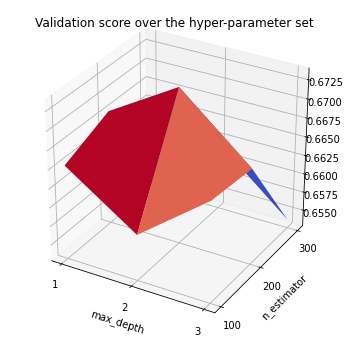

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig = plt.figure(figsize=(6,6))

ax2 = fig.add_subplot(1, 1, 1)

# x = np.arange(10)
# ticks = ["dataset 0", "dataset 1", "dataset 2", "dataset 3", "dataset 4", "dataset 5", "dataset 6", "dataset 7", "dataset 8", "dataset 9"]
# ticks = str(x)
# tr = np.array([0.935302594, 0.935302594, 0.935302594, 0.93443804, 0.93443804, 0.934726225, 0.93832853, 0.959510086, 0.939769452, 0.960086455])
# val = np.array([0.643804035, 0.643804035, 0.643804035, 0.640345821, 0.640345821, 0.606340058, 0.608069164, 0.489337176, 0.614409222, 0.495100865])
# bar_width = 0.35
# ax1.bar(x,tr,bar_width,label='Training score')
# ax1.bar(x+bar_width,val,bar_width,label='Validation score')
# ax1.legend()
# ax1.set_xticks(x)
# ax1.set_xlabel('Dataset')
# # ax1.set_xticklabels(x)
# ax1.set_ylim([0,1])
# ax1.set_yticks(np.linspace(0,1,11))
# ax1.set_title('Training results on the initial step')
np.random.seed(10)
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
x = np.array([1,2,3])
y = np.array([100,200,300])
X, Y = np.meshgrid(x,y)
Z = np.array([[0.6576368876080692,0.6587896253602306,0.659942363112392],[0.6605187319884727,0.6685878962536023,0.6634005763688761],[0.6512968299711815,0.6542968299711815,0.6522968299711815]])+np.random.rand(3,3)*0.01
ax2.plot_surface(X,Y,Z,cmap=cm.coolwarm)
ax2.set_title('Validation score over the hyper-parameter set')
ax2.set_xticks(x)
ax2.set_yticks(y)
ax2.set_zticks(np.linspace(0.655, 0.668, 5))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('n_estimator')

- Further tuning

In [ ]:
depth_list = [3,5,10]
n_esti_list = [30,50,100]
for max_depth in depth_list:
  for n_esti in n_esti_list:
    xgb_clf = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=max_depth,n_estimators=n_esti,learning_rate=0.1)
    xgb_clf.fit(X_train_list[0],y_train)
    print(max_depth, n_esti)
    print('training score:', xgb_clf.score(X_train_list[0],y_train))
    print('test score:', xgb_clf.score(X_test_list[0],y_test))

In [ ]:
from xgboost import XGBClassifier
depth_list = [1,2,3]
n_esti_list = [100,200,300]
for max_depth in depth_list:
  for n_esti in n_esti_list:
    xgb_clf = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=max_depth,n_estimators=n_esti,learning_rate=0.1)
    xgb_clf.fit(X_train_list[1],y_train)
    print(max_depth, n_esti)
    print('training score:', xgb_clf.score(X_train_list[1],y_train))
    print('test score:', xgb_clf.score(X_test_list[1],y_test))

1 100
training score: 0.6926512968299712
test score: 0.6576368876080692
1 200
training score: 0.7293948126801153
test score: 0.6587896253602306
1 300
training score: 0.7540345821325648
test score: 0.659942363112392
2 100
training score: 0.7701729106628242
test score: 0.6605187319884727
2 200
training score: 0.8403458213256484
test score: 0.6685878962536023
2 300
training score: 0.8884726224783862
test score: 0.6634005763688761
3 100
training score: 0.8618155619596541
test score: 0.6512968299711815


KeyboardInterrupt: ignored

In [ ]:
from xgboost import XGBClassifier
xgb_clf_tmp = XGBClassifier(gpu_id=0,tree_method='gpu_hist',learning_rate=0.1)
xgb_clf_tmp.fit(X_train_list[1],y_train)
print('training score:', xgb_clf_tmp.score(X_train_list[1],y_train))
print('test score:', xgb_clf_tmp.score(X_test_list[1],y_test))

training score: 0.8618155619596541
test score: 0.6512968299711815


- CatBoosting

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier
ctb_clf_list = []
for ielem, X_train in enumerate(X_train_list):
  print(ielem)
  ctb_clf = CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
  # ctb_clf = CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',verbose=False)
  ctb_clf.fit(X_train,y_train)
  ctb_clf_list.append(ctb_clf)

0
1
2
3
4
5
6
7
8
9


In [ ]:
for ielem, ctb_clf in enumerate(ctb_clf_list):
  print('design matrix', ielem)
  print('training score:', ctb_clf.score(X_train_list[ielem],y_train))
  print('test score:', ctb_clf.score(X_test_list[ielem],y_test))
# possible try would be increase the n_feats when we apply tfid vectorizer to our clean post

design matrix 0
training score: 0.8720461095100864
test score: 0.6593659942363113
design matrix 1
training score: 0.8730547550432277
test score: 0.6645533141210375
design matrix 2
training score: 0.8746397694524496
test score: 0.6680115273775216
design matrix 3
training score: 0.8726224783861671
test score: 0.6645533141210375
design matrix 4
training score: 0.871613832853026
test score: 0.661671469740634
design matrix 5
training score: 0.995821325648415
test score: 0.6363112391930835
design matrix 6
training score: 0.9945244956772334
test score: 0.6386167146974063
design matrix 7
training score: 0.9994236311239193
test score: 0.5469740634005764
design matrix 8
training score: 0.9969740634005764
test score: 0.6449567723342939
design matrix 9
training score: 0.9995677233429395
test score: 0.5642651296829971


In [ ]:
ctb_clf_tmp = CatBoostClassifier(max_depth=2,loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
ctb_clf_tmp.fit(X_train_list[2],y_train)
print('training score:', ctb_clf_tmp.score(X_train_list[2],y_train))
print('test score:', ctb_clf_tmp.score(X_test_list[2],y_test))

training score: 0.725792507204611
test score: 0.6610951008645534


**5. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
decision_tree = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[6,7,8,9,10,15,20]}
dt_clf = GridSearchCV(decision_tree, parameters)

In [ ]:
dt_clf.fit(train_design, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8, 9, 10, 15, 20]})

In [ ]:
# summarize result
print('Best Score: %s' % dt_clf.best_score_)
print('Best Hyperparameters: %s' % dt_clf.best_params_)

Best Score: 0.49956772334293953
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 8}


In [ ]:
best_dt_clf = DecisionTreeClassifier(criterion='gini',max_depth=8)
best_dt_clf.fit(X_train,y_train)

print('training error:', best_dt_clf.score(X_train,y_train))
print('test error:', best_dt_clf.score(X_test,y_test))

training error: 0.6027377521613833
test error: 0.49279538904899134


**6. Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier()

rf_space = dict()
rf_space['n_estimators'] = [50,100,150]
rf_space['max_depth'] = [6,7,8,9,10,15,20]
rf_space['criterion'] = ['gini', 'entropy']
rf_space['min_samples_leaf'] = range(1,5)                         

rf_search = RandomizedSearchCV(random_forest, rf_space, scoring='accuracy', n_jobs=-1, cv=5, random_state=1)

In [ ]:
# execute search
rf_result = rf_search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)

Best Score: 0.5456772334293948
Best Hyperparameters: {'n_estimators': 50, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'gini'}


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=3)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=200)

In [ ]:
print(rf_clf.score(X_train,y_train))
print(rf_clf.score(X_test,y_test))

0.9961095100864553
0.27780979827089336


**7. MLP Classifier**

#Test accuracy 
- Label vs MBTI type from our classifier
- Label vs Each axis (I/E N/S F/T J/P) from our classifer

<!-- -Second
  - MBTI from the model vs Each axis result from the model (could be interpreted for each axis)
    - From MBTI multiclass classifier -> INFJ
    - From each axis classifier -> E N F J -->

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


# We need to use Multi-label/Multioutput classification. <- we define clf and glue them using MultiOutputClassifier
# https://scikit-learn.org/stable/modules/multiclass.html



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

**Log Reg**

In [ ]:
y_pred = best_logreg.predict(test_design)
print("Accuracy Score: ", accuracy_score(y_pred, test_target))
cm_logistic = confusion_matrix(test_target, y_pred)

Accuracy Score:  0.5827089337175793


**SVM**

In [ ]:
y_pred = best_svm_clf.predict(test_design)
print("Accuracy Score: ", accuracy_score(y_pred, test_target))
cm_svm = confusion_matrix(test_target, y_pred)

NameError: ignored

## Confusion Matrix Visualization

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(13, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

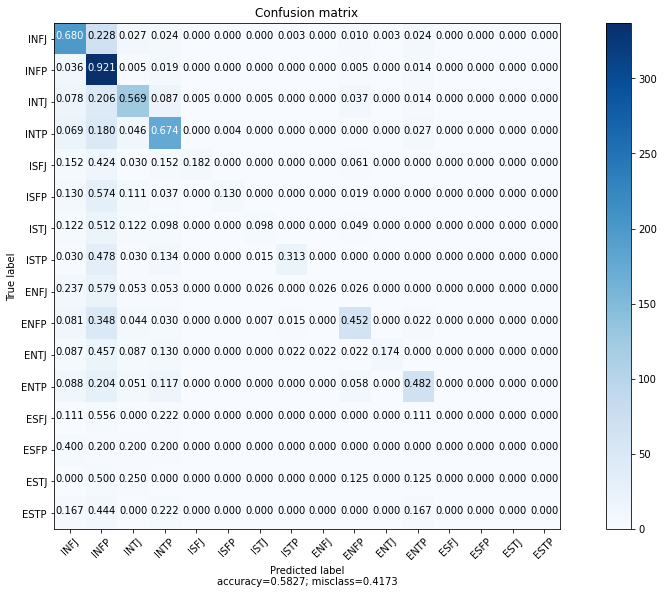

In [ ]:
plot_confusion_matrix(cm_logistic, list(class16_mbti_map.values()))